<a href="https://colab.research.google.com/github/rlagp12/BIO165_final-project/blob/main/Copy_of_THEsolution_BIO165_W8_drylab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 8 Dry Lab: 'omics

### Logistics

#### Jupyter notebooks

We will use Jupyter based notebooks like this to run the dry labs. The notebooks will guide you through the dry labs each week, containing some markdown cells with some background information, <font color=orange> exercises</font>, and example or skeleton code for exercises.

In this class, data and code will be made available through Canvas. All of the homework submissions will be individual but we still highly encourage you to work in teams. For each homework submission you'll be asked to submit your code (this Jupyter workbook once you have worked through it) as a PDF via Gradescope. To save a pdf version of your notebook in VSCode, click on the three dots next to outline in VSCode, choose "export" and then choose the pdf option. Alternatively, choose export and then the HTML option, open the html file (in your browser), click print with the destination "save as a PDF". Please submit your pdf on gradescope and indicate location of your answer for each question. Homework is due **<font color=lightblue> on Thursday 03/06/2025 at 11:59 pm</font>**.



### This week

This week, we will dive into analyzing an RNA-Seq database from Jackson et al (eLife, 2020) using the tools we've discussed this week in class.

We will cover the following topics:

1. Considering noise in omics data using bulk RNA-seq data
2. Checking for noise in single-cell RNA-Seq data using a pseudobulk analysis
3. Visualizing single-cell RNA-Seq data using PCA and UMAP
4. Clustering sub-populations of cells from single-cell RNA-Seq data
4. Simple gene networks and protein oscillations

To complete this lab you will need:

1. This Jupyter notebook
2. A Python IDE (you can use Anaconda, Visual Studio, or PyCharm), which you already set up before
3. bulk RNA-Seq data from Jackson et al, (`YPD_bulk.tsv`)
4. single-cell RNA-Seq data from Jackson et al (`jackson_data_YPD_proline_CStarve.tsv`)
5. gene group labels, (`gene_groups.tsv`)


In [1]:
# run this if you have not installed pyDESeq2 or umap-learn
!pip install pyDESeq2
!pip install umap-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=47022dba9c4dbc8c585f904a329a8bc30e36addcea01f3c27d3627570546b6fe
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info


In [2]:
# the first step for most code

# import libraries

# standard libraries
import os
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt

# differential expression
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# dimentionality reduction and clustering
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import umap
# Anaconda should automatically install all of these libraries, but if this does not work you might not
# have these libraries installed. If this is the case, you can install them using pip install.

In [3]:
# bulk data
bulk_data = pd.read_csv("/content/karim_etal_data.csv", sep=',',index_col = 0).T
bulk_data

Geneid,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000277856,ENSG00000275063,ENSG00000271254,ENSG00000275405,ENSG00000275987,ENSG00000277475,ENSG00000268674
1,0,41,0,3,0,0,0,0,0,0,...,0,0,0,0,0,249,0,0,3,0
2,0,66,0,2,0,0,0,0,0,0,...,0,0,0,0,0,372,0,1,0,0
3,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,0,221,0,0,0,0
4,0,37,0,3,0,0,0,0,0,0,...,0,0,0,0,0,274,0,1,0,0
5,0,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,232,0,0,0,0
6,0,50,0,0,0,0,1,0,0,0,...,0,0,0,0,0,235,0,0,0,0
7,0,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,259,0,0,0,0
8,0,51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,237,0,0,0,0
9,0,34,1,1,0,0,0,0,0,0,...,0,0,0,0,0,130,0,0,1,0
10,0,41,2,0,0,0,0,0,0,0,...,0,0,0,0,0,114,0,0,0,0


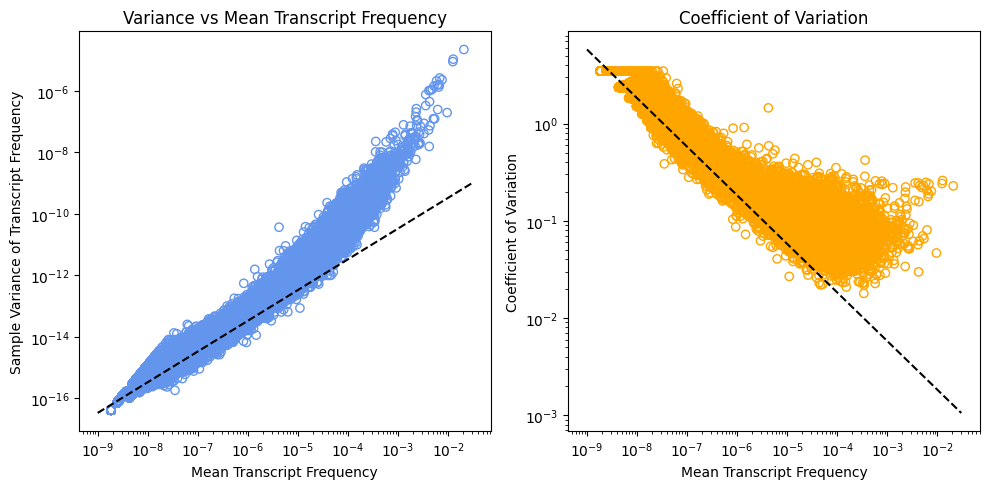

In [4]:
# SOLUTION
bulk_data_normalized = bulk_data.div(bulk_data.sum(axis=1), axis=0)
bulk_data_normalized

# compare mean to variance - see that poisson actually isn't a good deascription
mean_values = bulk_data_normalized.mean()
var_values = bulk_data_normalized.var()

# Create the figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
freq_values = np.linspace(1E-9, 3E-2, 100)
n_samples = bulk_data.shape[0] #number of samples
n_transcripts = bulk_data.shape[1]
total_reads = bulk_data.values.sum()
n_reads = int(total_reads/n_samples) # number of reads per sample (sequencing depth)

ax1.plot(freq_values, freq_values/n_reads, c="black", ls="--")
ax1.scatter(mean_values, var_values, facecolor="none", edgecolor='cornflowerblue')
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel("Mean Transcript Frequency")
ax1.set_ylabel("Sample Variance of Transcript Frequency")
ax1.set_title("Variance vs Mean Transcript Frequency")

# Second subplot
ax2.scatter(mean_values, bulk_data_normalized.std(ddof=1)/mean_values, facecolor="none", edgecolor='orange')
ax2.plot(freq_values, np.sqrt(1/(freq_values*n_reads)), c="black", ls="--")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel("Mean Transcript Frequency")
ax2.set_ylabel("Coefficient of Variation")
ax2.set_title("Coefficient of Variation")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

In [5]:
# simulation of noise with a multinomial process

# extract parameters for the simulation from the bulk data
n_samples = bulk_data.shape[0] #number of samples
n_transcripts = bulk_data.shape[1]
total_reads = bulk_data.values.sum()
n_reads = int(total_reads/n_samples) # number of reads per sample (sequencing depth)
probabilities = bulk_data.sum(axis = 0).values/total_reads


# Array to store all samples
sample_counts = np.zeros((n_samples, n_transcripts), dtype=int)

# Sample n_samples times and store the results in a 2D array
# each row is a sample, each column is a gene
for i in range(n_samples):
    sample_counts[i] = np.random.multinomial(n_reads, probabilities)



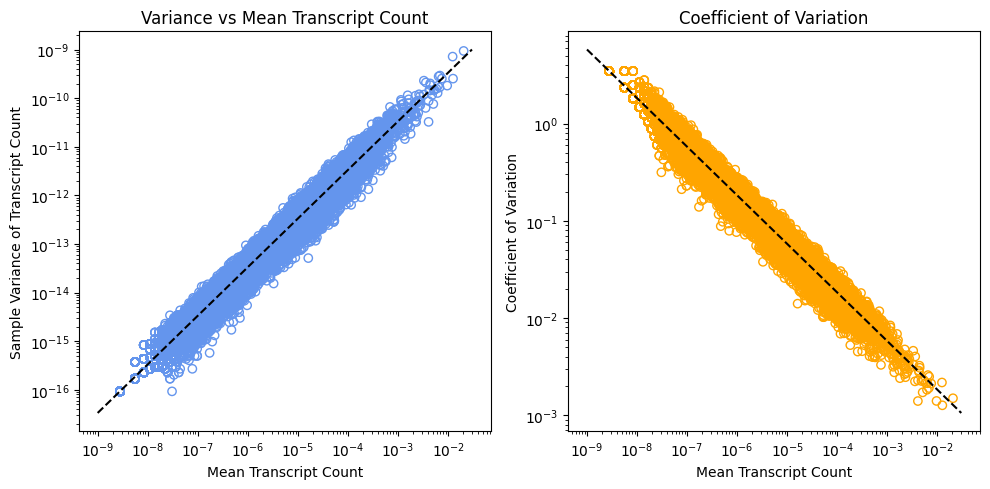

In [6]:
# SOLUTION
# Create the figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sample_counts = pd.DataFrame(sample_counts)
sample_counts_normalized = sample_counts.div(sample_counts.sum(axis=1), axis=0)
sample_counts_normalized

# First subplot
ax1.scatter(sample_counts_normalized.mean(axis = 0), sample_counts_normalized.var(ddof=1, axis = 0), facecolor="none", edgecolor='cornflowerblue')
ax1.plot(freq_values, freq_values/n_reads, c="black", ls="--")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel("Mean Transcript Count")
ax1.set_ylabel("Sample Variance of Transcript Count")
ax1.set_title("Variance vs Mean Transcript Count")

# Second subplot
ax2.scatter(sample_counts_normalized.mean(axis = 0), sample_counts_normalized.std(ddof=1, axis = 0)/sample_counts_normalized.mean(axis = 0), facecolor="none", edgecolor='orange')
binom_pvals = np.linspace(1, np.max(sample_counts_normalized), 100)
ax2.plot(freq_values, np.sqrt(1/(freq_values*n_reads)), c="black", ls="--")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel("Mean Transcript Count")
ax2.set_ylabel("Coefficient of Variation")
ax2.set_title("Coefficient of Variation")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.008346  0.001557 -0.000932 -0.000148 -0.000070  0.000093  0.000382   
1  0.000163  0.003456 -0.000068  0.000397  0.000323  0.000963 -0.000284   
2 -0.007689  0.000484 -0.002272 -0.001235 -0.000248 -0.000476  0.000069   
3  0.009141  0.003187  0.001500 -0.000857  0.000308 -0.000548  0.000066   
4 -0.003005 -0.001064  0.002392 -0.000097 -0.000540  0.000182  0.000716   

        PC8       PC9      PC10  
0  0.000738 -0.000051 -0.000251  
1 -0.000185  0.000313  0.000060  
2 -0.000432  0.000101  0.000076  
3 -0.000060 -0.000355  0.000045  
4 -0.000250  0.000180 -0.000131  


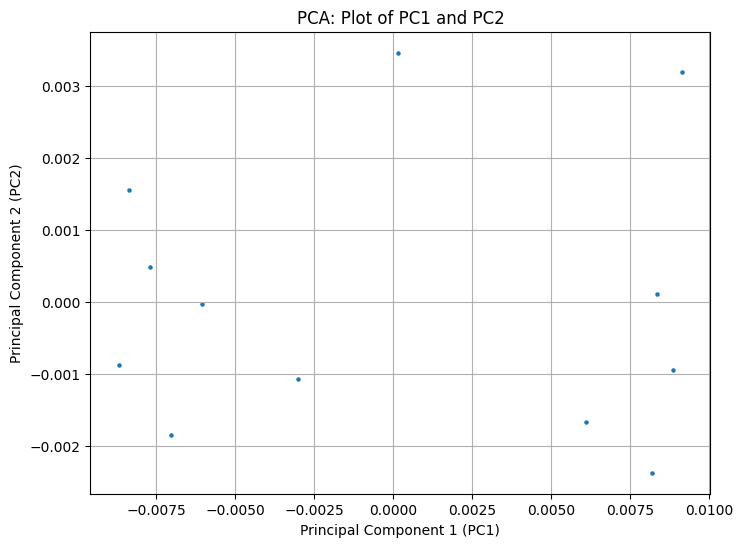

In [7]:
# Grab YPD counts

n_PCA_Comps = 10  # Number of PCs to generate

# Perform PCA
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(bulk_data_normalized)

# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])

# View the first few rows of the PCA results
print(pca_df.head())

# Plot the points in PC1 and PC2
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5)

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA: Plot of PC1 and PC2')

plt.grid(True)
plt.show()


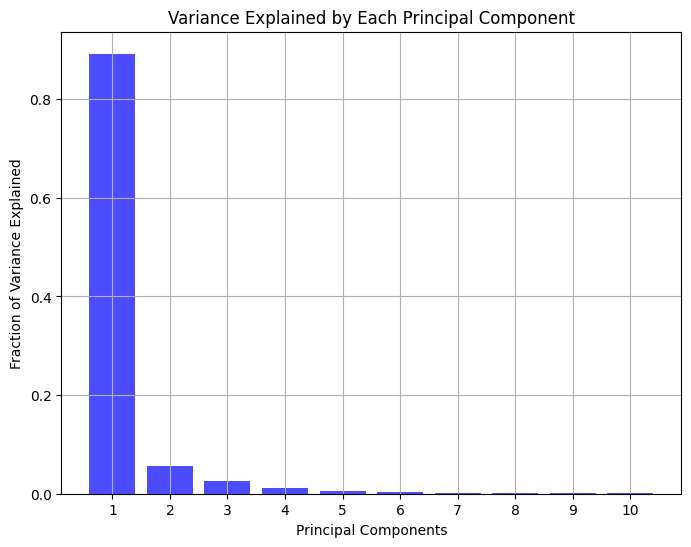

In [8]:
# Plot the fraction of variance captured by each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_PCA_Comps + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xlabel('Principal Components')
plt.ylabel('Fraction of Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, n_PCA_Comps + 1))
plt.grid(True)
plt.show()

In [9]:
sum(pca.explained_variance_ratio_)

0.9995092918069718

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


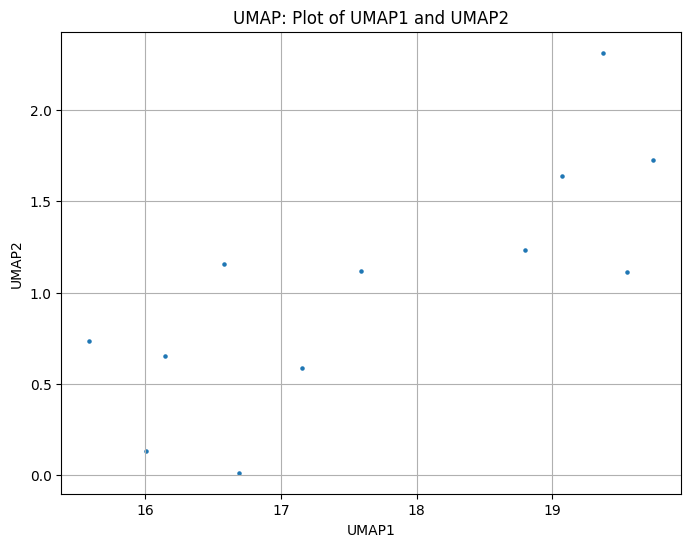

In [10]:
# UMAP without scaling
# Step 2: Perform UMAP
umap_model = umap.UMAP(n_components=2)

umap_components = umap_model.fit_transform(bulk_data_normalized)

# Step 3: Create a DataFrame of the UMAP results
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])

# Step 4: Plot UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], marker='o', s = 5)

# Add labels and title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP: Plot of UMAP1 and UMAP2')

# Show the plot
plt.grid(True)
plt.show()

Adjusted and Normalized Bulk Data Shape: (12, 57500)
Adjusted and Normalized Bulk Data Head:
Geneid  ENSG00000223972  ENSG00000227232  ENSG00000278267  ENSG00000243485  \
1          1.000000e-12         0.000001     1.000000e-12     9.518045e-08   
2          1.000000e-12         0.000001     1.000000e-12     4.432574e-08   
3          1.000000e-12         0.000002     1.000000e-12     1.000000e-12   
4          1.000000e-12         0.000001     1.000000e-12     8.944103e-08   
5          1.000000e-12         0.000001     1.000000e-12     1.000000e-12   

Geneid  ENSG00000237613  ENSG00000268020  ENSG00000240361  ENSG00000186092  \
1          1.000000e-12     1.000000e-12     1.000000e-12     1.000000e-12   
2          1.000000e-12     1.000000e-12     1.000000e-12     1.000000e-12   
3          1.000000e-12     1.000000e-12     1.000000e-12     1.000000e-12   
4          1.000000e-12     1.000000e-12     1.000000e-12     1.000000e-12   
5          1.000000e-12     1.000000e-12     1.0

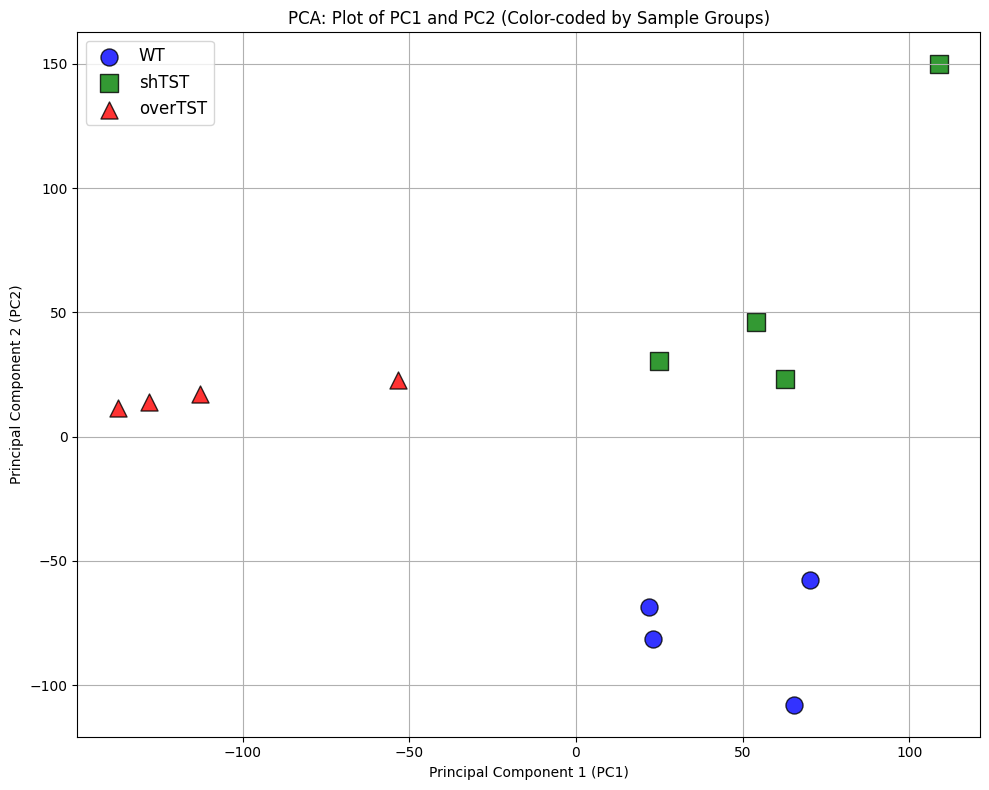

In [11]:
# Replace zero values with a very small number (epsilon)
epsilon = 1e-12
bulk_data_normalized.replace(0, epsilon, inplace=True)

# Display structure and first few rows of bulk_data_normalized
print("Adjusted and Normalized Bulk Data Shape:", bulk_data_normalized.shape)
print("Adjusted and Normalized Bulk Data Head:")
print(bulk_data_normalized.head())

# Normalize the data by standardizing (mean=0, std=1)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(bulk_data_normalized)

# Number of principal components to generate
n_PCA_Comps = 10

# Perform PCA on the normalized data
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(normalized_data)

# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])
pca_df['Sample'] = bulk_data_normalized.index  # Add sample labels for color coding

# Define groups for color coding
def categorize_sample(sample):
    if sample in ['1', '2', '3', '4']:
        return 'WT'
    elif sample in ['5', '6', '7', '8']:
        return 'shTST'
    elif sample in ['9', '10', '11', '12']:
        return 'overTST'

pca_df['Group'] = pca_df['Sample'].apply(categorize_sample)

# View the first few rows of the PCA results
print("PCA DataFrame Head:")
print(pca_df.head())

# Plot the points in PC1 and PC2, color-coded by groups
plt.figure(figsize=(10, 8))

# Unique groups for color coding
unique_groups = pca_df['Group'].unique()
colors = ['blue', 'green', 'red']  # Distinct colors for better visualization
markers = ['o', 's', '^']  # Different markers for each group

for group, color, marker in zip(unique_groups, colors, markers):
    subset = pca_df[pca_df['Group'] == group]
    plt.scatter(subset['PC1'], subset['PC2'], marker=marker, s=150, color=color, label=group, alpha=0.8, edgecolor='k')

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA: Plot of PC1 and PC2 (Color-coded by Sample Groups)')
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels/legend
plt.show()

# DeSeq analysis
## Data obtained from the RNAseq data was analysed and condition pairs were compared: overTST or shTST vs WT

In [12]:
bulk_data
bulk_data["Condition"] = ["WT"] * 4 + ["shTST"] * 4 + ["overTST"] * 4
bulk_data.head()

Geneid,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000276351,ENSG00000275661,ENSG00000277856,ENSG00000275063,ENSG00000271254,ENSG00000275405,ENSG00000275987,ENSG00000277475,ENSG00000268674,Condition
1,0,41,0,3,0,0,0,0,0,0,...,0,0,0,0,249,0,0,3,0,WT
2,0,66,0,2,0,0,0,0,0,0,...,0,0,0,0,372,0,1,0,0,WT
3,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,221,0,0,0,0,WT
4,0,37,0,3,0,0,0,0,0,0,...,0,0,0,0,274,0,1,0,0,WT
5,0,39,0,0,0,0,0,0,0,0,...,0,0,0,0,232,0,0,0,0,shTST


In [13]:

# SOLUTION

rep_cluster_labels = bulk_data.Condition
bulk_data = bulk_data.drop(["Condition"], axis=1)
bulk_data


Geneid,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000277856,ENSG00000275063,ENSG00000271254,ENSG00000275405,ENSG00000275987,ENSG00000277475,ENSG00000268674
1,0,41,0,3,0,0,0,0,0,0,...,0,0,0,0,0,249,0,0,3,0
2,0,66,0,2,0,0,0,0,0,0,...,0,0,0,0,0,372,0,1,0,0
3,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,0,221,0,0,0,0
4,0,37,0,3,0,0,0,0,0,0,...,0,0,0,0,0,274,0,1,0,0
5,0,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,232,0,0,0,0
6,0,50,0,0,0,0,1,0,0,0,...,0,0,0,0,0,235,0,0,0,0
7,0,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,259,0,0,0,0
8,0,51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,237,0,0,0,0
9,0,34,1,1,0,0,0,0,0,0,...,0,0,0,0,0,130,0,0,1,0
10,0,41,2,0,0,0,0,0,0,0,...,0,0,0,0,0,114,0,0,0,0


# This is for overTST vs WT

In [14]:
# differential expression analysis
# no need to edit this block

# Prepare the count matrix (proline_counts)
count_matrix = bulk_data.values  # Convert to numpy array
genes = bulk_data.columns  # Gene names
samples = bulk_data.index  # Sample names

# Prepare the condition labels (kmeans_labels)
condition_labels = rep_cluster_labels  # Condition labels (0 or 1 from k-means)

# Ensure that condition_labels corresponds to the sample order
if len(condition_labels) != len(samples):
    raise ValueError("Condition labels must match the number of samples.")

# 3. Create the DeseqDataSet object
# Create a metadata dataframe for conditions
metadata = pd.DataFrame({'condition': condition_labels}, index=samples)

# Create the DeseqDataSet using count matrix and metadata
dds = DeseqDataSet(counts=count_matrix, metadata=metadata)


# Initialize inference engine
inference = DefaultInference(n_cpus=8)

# Create the DESeq2 dataset
dds = DeseqDataSet(
    counts=count_matrix,
    metadata=metadata,
)

dds.deseq2()
# Extract results
res = DeseqStats(dds, contrast=["condition", "overTST", "WT"])
res.summary()

# Get the results as a DataFrame
DE_results_df = res.results_df
DE_results_df["gene_name"] = list(bulk_data.columns)
display(DE_results_df.head())

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 34.66 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 38.15 seconds.

Fitting LFCs...
... done in 25.35 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 13.87 seconds.



Log2 fold change & Wald test p-value: condition overTST vs WT
         baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0        0.000000             NaN       NaN       NaN           NaN       NaN
1       44.423694       -0.015745  0.246878 -0.063775  9.491491e-01  0.971015
2        0.678557        2.926602  2.579213  1.134688  2.565061e-01       NaN
3        0.843199       -0.945326  1.735374 -0.544739  5.859328e-01       NaN
4        0.000000             NaN       NaN       NaN           NaN       NaN
...           ...             ...       ...       ...           ...       ...
57495  206.716906       -0.583825  0.111836 -5.220374  1.785623e-07  0.000002
57496    0.000000             NaN       NaN       NaN           NaN       NaN
57497    0.128624       -0.880281  4.051553 -0.217270  8.279980e-01       NaN
57498    0.318246       -0.889074  3.443010 -0.258226  7.962327e-01       NaN
57499    0.000000             NaN       NaN       NaN           NaN       NaN

[

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
0,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000223972
1,44.423694,-0.015745,0.246878,-0.063775,0.949149,0.971015,ENSG00000227232
2,0.678557,2.926602,2.579213,1.134688,0.256506,NaN,ENSG00000278267
3,0.843199,-0.945326,1.735374,-0.544739,0.585933,NaN,ENSG00000243485
4,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000237613


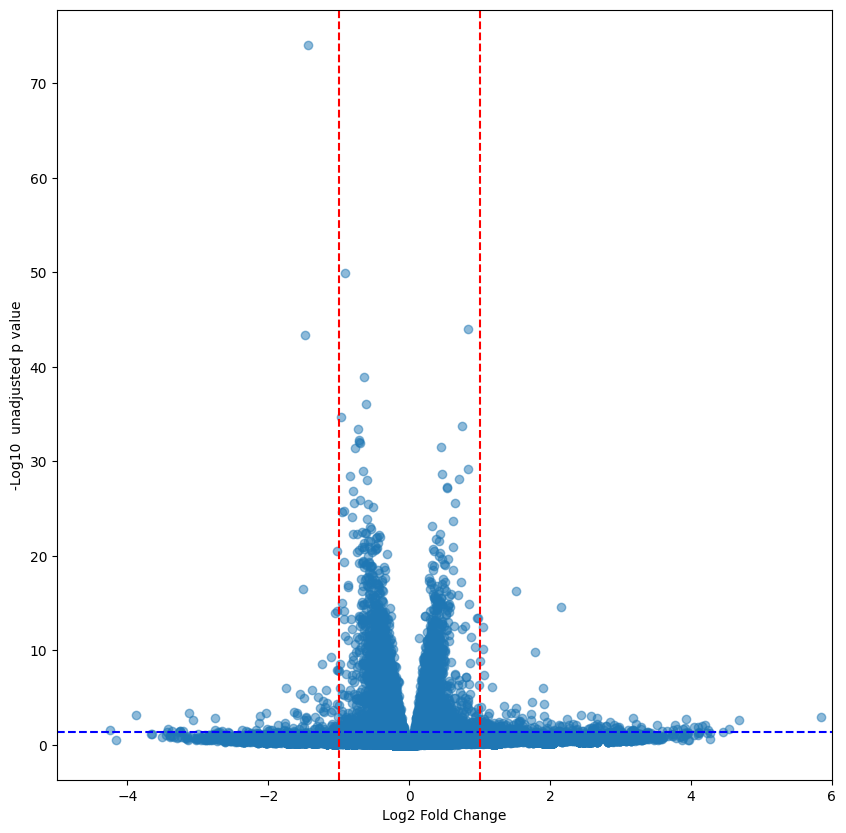

In [15]:
# SOLUTION
plt.figure(figsize=(10,10))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.pvalue), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  unadjusted p value")
plt.xlim([-5, 6])  # Limits x-axis to -2 to 2

plt.show()


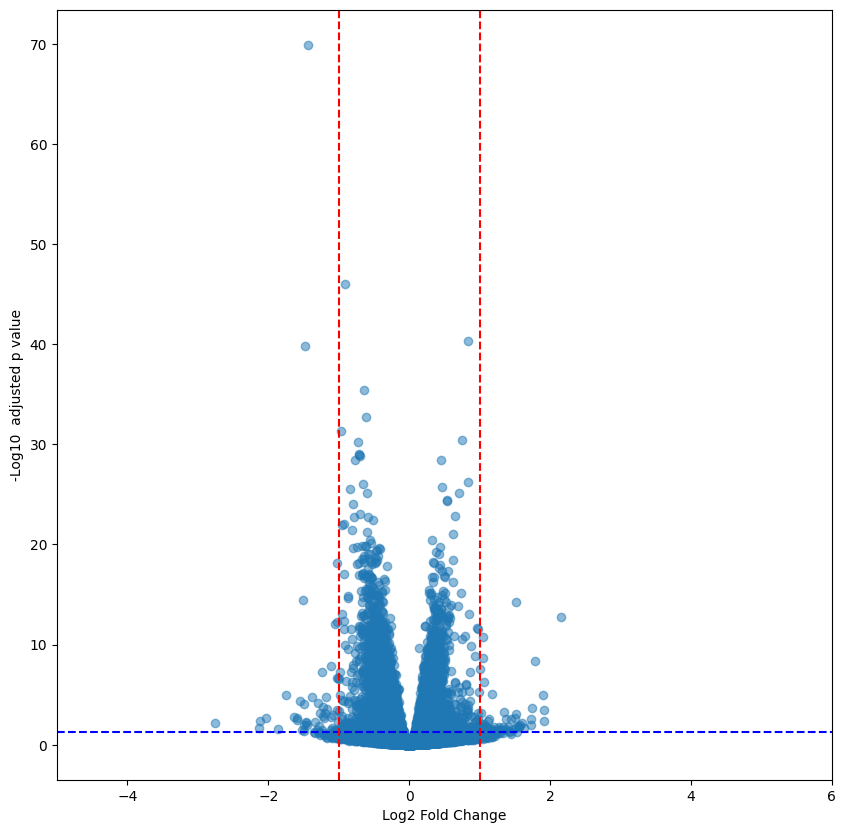

In [16]:
# SOLUTION
plt.figure(figsize=(10,10))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.padj), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")
plt.xlim([-5, 6])
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  adjusted p value")

plt.show()


In [17]:
upregulated_genes = DE_results_df[(DE_results_df["log2FoldChange"] > 1) &
                           (DE_results_df["padj"] < 0.05)]

print(upregulated_genes.shape)
upregulated_genes.head()
# Save to CSV
upregulated_genes.to_csv("upregulated_genes.csv", index=True)  # Keep index if gene names are there


(56, 7)


In [18]:
downregulated_genes = DE_results_df[(DE_results_df["log2FoldChange"] < -1) &
                           (DE_results_df["padj"] < 0.05)]

print(downregulated_genes.shape)
downregulated_genes.head()
# Save to CSV
downregulated_genes.to_csv("downregulated_genes.csv", index=True)  # Keep index if gene names are there

(48, 7)


# This is for shTST vs WT

In [19]:
# differential expression analysis
# no need to edit this block

# Prepare the count matrix (proline_counts)
count_matrix = bulk_data.values  # Convert to numpy array
genes = bulk_data.columns  # Gene names
samples = bulk_data.index  # Sample names

# Prepare the condition labels (kmeans_labels)
condition_labels = rep_cluster_labels  # Condition labels (0 or 1 from k-means)

# Ensure that condition_labels corresponds to the sample order
if len(condition_labels) != len(samples):
    raise ValueError("Condition labels must match the number of samples.")

# 3. Create the DeseqDataSet object
# Create a metadata dataframe for conditions
metadata = pd.DataFrame({'condition': condition_labels}, index=samples)

# Create the DeseqDataSet using count matrix and metadata
dds = DeseqDataSet(counts=count_matrix, metadata=metadata)


# Initialize inference engine
inference = DefaultInference(n_cpus=8)

# Create the DESeq2 dataset
dds = DeseqDataSet(
    counts=count_matrix,
    metadata=metadata,
)

dds.deseq2()
# Extract results
res_sh = DeseqStats(dds, contrast=["condition", "shTST", "WT"])
res_sh.summary()

# Get the results as a DataFrame
DE_results_df_sh = res_sh.results_df
DE_results_df_sh["gene_name"] = list(bulk_data.columns)
display(DE_results_df_sh.head())

Fitting size factors...
... done in 0.04 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 32.75 seconds.

Fitting dispersion trend curve...
... done in 1.00 seconds.

Fitting MAP dispersions...
... done in 38.28 seconds.

Fitting LFCs...
... done in 24.95 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 14.24 seconds.



Log2 fold change & Wald test p-value: condition shTST vs WT
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0        0.000000             NaN       NaN       NaN       NaN       NaN
1       44.423694        0.075233  0.239431  0.314216  0.753357  0.871359
2        0.678557        2.489468  2.587534  0.962100  0.335999       NaN
3        0.843199       -3.247927  2.262411 -1.435604  0.151115       NaN
4        0.000000             NaN       NaN       NaN       NaN       NaN
...           ...             ...       ...       ...       ...       ...
57495  206.716906       -0.012399  0.103188 -0.120161  0.904356  0.953383
57496    0.000000             NaN       NaN       NaN       NaN       NaN
57497    0.128624       -1.204370  4.051571 -0.297260  0.766268       NaN
57498    0.318246       -1.934508  3.601006 -0.537213  0.591120       NaN
57499    0.000000             NaN       NaN       NaN       NaN       NaN

[57500 rows x 6 columns]


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
0,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000223972
1,44.423694,0.075233,0.239431,0.314216,0.753357,0.871359,ENSG00000227232
2,0.678557,2.489468,2.587534,0.962100,0.335999,NaN,ENSG00000278267
3,0.843199,-3.247927,2.262411,-1.435604,0.151115,NaN,ENSG00000243485
4,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000237613


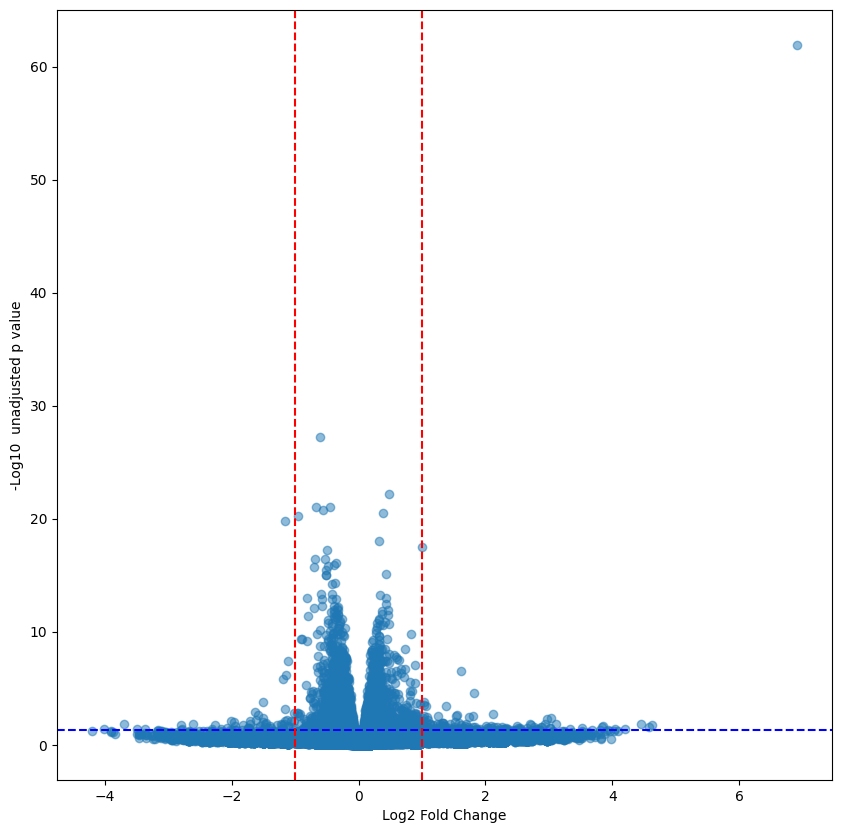

In [21]:
# SOLUTION
plt.figure(figsize=(10,10))
plt.scatter(DE_results_df_sh.log2FoldChange, -np.log10(DE_results_df_sh.pvalue), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  unadjusted p value")

plt.show()


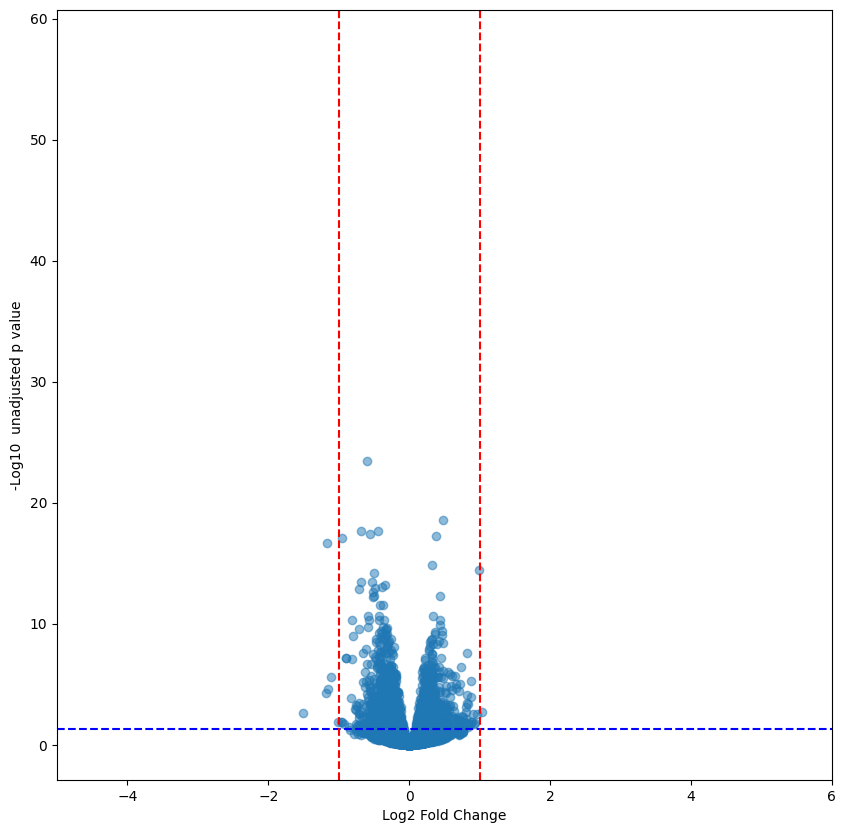

In [28]:
# SOLUTION
plt.figure(figsize=(10,10))
plt.scatter(DE_results_df_sh.log2FoldChange, -np.log10(DE_results_df_sh.padj), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")
plt.xlim([-5, 6])
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  unadjusted p value")

plt.show()


In [22]:
upregulated_genes_sh = DE_results_df_sh[(DE_results_df_sh["log2FoldChange"] > 1) &
                           (DE_results_df_sh["padj"] < 0.05)]

print(upregulated_genes_sh.shape)
upregulated_genes_sh.head()
# Save to CSV
upregulated_genes_sh.to_csv("upregulated_genes_sh.csv", index=True)  # Keep index if gene names are there

(2, 7)


In [23]:
downregulated_genes_sh = DE_results_df_sh[(DE_results_df_sh["log2FoldChange"] < -1) &
                           (DE_results_df_sh["padj"] < 0.05)]

print(downregulated_genes_sh.shape)
downregulated_genes_sh.head()
# Save to CSV
downregulated_genes_sh.to_csv("downregulated_genes_sh.csv", index=True)  # Keep index if gene names are there

(6, 7)


0.3205421509511627


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


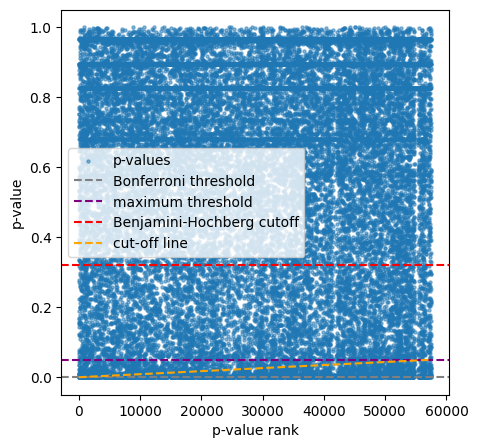

In [26]:
# SOLUTION
# Benjamini-hochberg correction
# first write code to find the threshold for the cut-off

# list of all the p-values
all_pvals = list(DE_results_df_sh.pvalue.values)
all_pvals.sort() # sort in increasing order
n_tests = DE_results_df_sh.shape[0]
alpha = 0.05
# get the alpha cutoff values be drawing a line between the Bonferroni cutoff (0.08/n_tests) and the original threshold (0.08)
alpha_cutoff = np.arange(0, n_tests)*((alpha - alpha/n_tests))/n_tests + alpha/n_tests

# find the p-values that are below the alpha-cutoff line
n_pvals_below_cutoff = len([x for x in alpha_cutoff - all_pvals if x >= 0])

# as the p-values are aranged in increasing order, we can find the new threshold by looking at the value in index n_pvals_below_cutoff - 1:
BH_pval_threshold = all_pvals[n_pvals_below_cutoff-1]
print(BH_pval_threshold)

# make the figure showing the Benjamini-Hochberg cutoffs
# you don't need to make this figure for full credit; this is just to demonstrate what the code is doing!
plt.figure(figsize=(5,5))
plt.scatter(np.arange(0, n_tests), all_pvals, s = 5, alpha= 0.5, label = "p-values")
plt.axhline(alpha/n_tests, c = "grey", ls = "--", label = "Bonferroni threshold")
plt.axhline(alpha, ls = "--", c = "purple", label = "maximum threshold")
plt.axhline(BH_pval_threshold, ls = "--", c = "red", label = "Benjamini-Hochberg cutoff")
plt.plot([0,n_tests-1], [alpha/n_tests, alpha], ls = "--", c = "orange", label =  "cut-off line")
plt.xlabel("p-value rank")
plt.ylabel("p-value")
plt.legend()
plt.show()

# add the significance calls from the BH cutoff:
DE_results_df["sig_BH"] = np.where((DE_results_df['pvalue'] < BH_pval_threshold), 1, 0)
DE_results_df["p_adj_BH"] = DE_results_df['pvalue'] * alpha/BH_pval_threshold

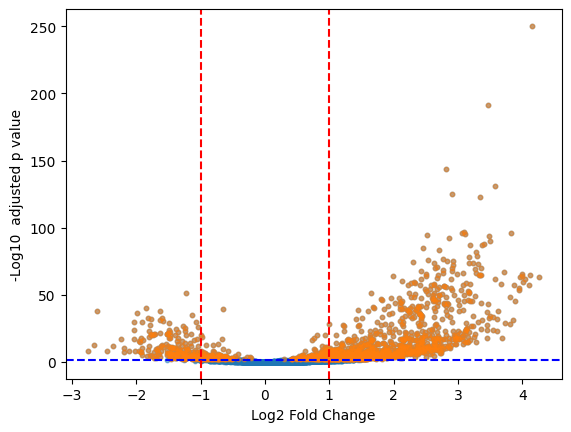

In [ ]:
# SOLUTION
# plt.figure(figsize=(5,5))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.pvalue), alpha = 0.5, s = 10)
sig_BH = DE_results_df.loc[DE_results_df.sig_BH == 1]
plt.scatter(sig_BH.log2FoldChange, -np.log10(sig_BH.pvalue), alpha = 0.5, s = 10)

# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  adjusted p value")

plt.show()

In [ ]:
#import gene group information
gene_groups = pd.read_csv("/Users/shailimathur/Documents/GitHub/W25_drylab_prep/data/gene_groups.tsv", sep='\t')
gene_groups.head()


,Gene,Group,Source
0,YDR417C,RP,Gasch_2017
1,YDR454C,RP,Gasch_2017
2,YEL026W,RP,Gasch_2017
3,YER025W,RP,Gasch_2017
4,YGL102C,RP,Gasch_2017


Text(0, 0.5, '-Log10  adjusted p value')

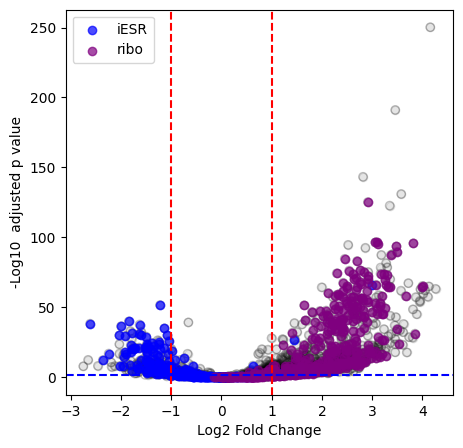

In [ ]:
# SOLUTION

iESR_genes = gene_groups[gene_groups.Group == "iESR"].Gene.values
ribo_genes = gene_groups[gene_groups.Group.isin(["RP", "RiBi"])].Gene.values

plt.figure(figsize=(5,5))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.pvalue), alpha = 0.5, facecolor = "none", edgecolors="grey")
sig_BH = DE_results_df.loc[DE_results_df.sig_BH == 1]
plt.scatter(sig_BH.log2FoldChange, -np.log10(sig_BH.pvalue), alpha = 0.1, c = "black")

iESR_results = DE_results_df.loc[DE_results_df.gene_name.isin(iESR_genes)]
plt.scatter(iESR_results.log2FoldChange, -np.log10(iESR_results.pvalue), alpha = 0.7, c = "blue", label = "iESR")

RP_results = DE_results_df.loc[DE_results_df.gene_name.isin(ribo_genes)]
plt.scatter(RP_results.log2FoldChange, -np.log10(RP_results.pvalue), alpha = 0.7, c = "purple", label = "ribo")

plt.legend()

# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  adjusted p value")


In [ ]:
# code for 4.6: edit this block

# we already have YPD_counts and proline_counts
CStarve_counts = jackson_data.loc[jackson_data.Condition == "CStarve"].iloc[:, :-5]

# Create a list of counts data
counts_by_env = [YPD_counts, CStarve_counts] # EDIT HERE TO ADD PROLINE
counts_by_env = [YPD_counts, CStarve_counts, proline_counts] # SOLUTION
UMAP_df_list = []

# Generate UMAP projections for each of the counts data
for counts_df in counts_by_env:
    umap_projection = umap_model.fit_transform(counts_df)
    umap_projection_df = pd.DataFrame(data=umap_projection, columns=['UMAP1', 'UMAP2'])
    UMAP_df_list.append(umap_projection_df)


# Ensure that the columns in the list exist in the DataFrame
iESR_columns = [col for col in iESR_genes if col in jackson_data.columns]
ribo_columns = [col for col in ribo_genes if col in jackson_data.columns]


/var/folders/gp/3sshrqs52zd8gw165f_7y35w0000gp/T/ipykernel_33943/349337490.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


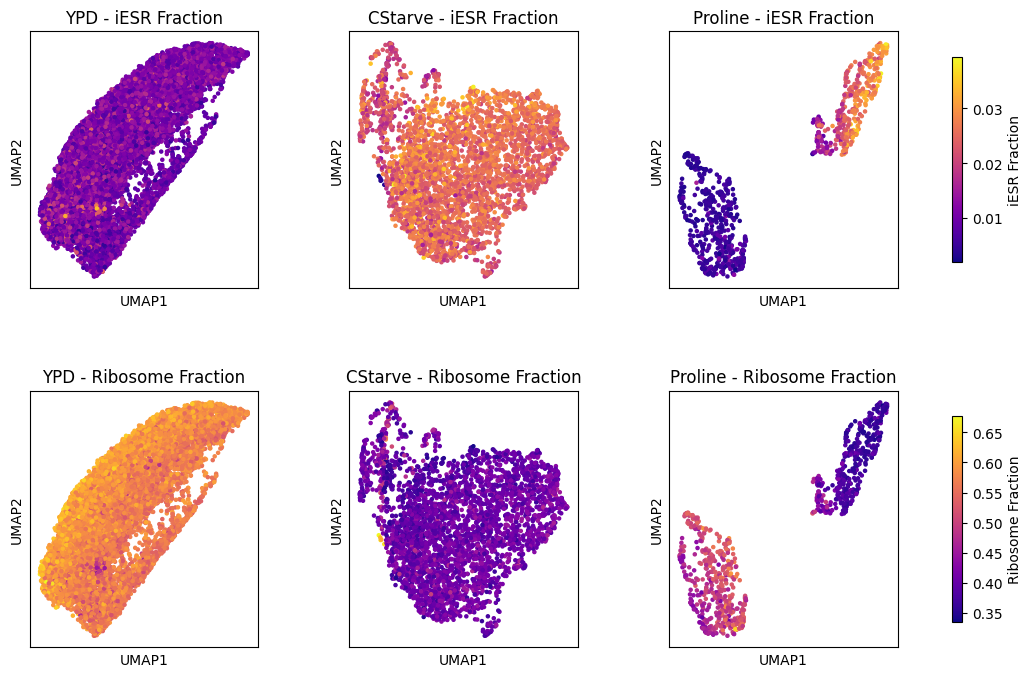

In [ ]:
# code for 4.6 (no need to edit this block; just look at the figure it generates)

# Create a figure with subplots (2 rows, len(counts_by_env) columns)
fig = plt.figure(figsize=(14, 8))  # Adjust figsize as needed
gs = fig.add_gridspec(2, len(counts_by_env), height_ratios=[1, 1], width_ratios=np.ones(len(counts_by_env)), hspace=0.4, wspace=0.4)

# Create axes for the top and bottom row
axes_top = [fig.add_subplot(gs[0, i]) for i in range(len(counts_by_env))]
axes_bottom = [fig.add_subplot(gs[1, i]) for i in range(len(counts_by_env))]

# Environment labels
env_labels = ["YPD", "CStarve", "Proline"]

# Plot UMAP in the top row with iESR fraction
scatters = []  # To hold scatter plot handles for the colorbar
for i, ax in enumerate(axes_top):  # Top row
    umap_df = UMAP_df_list[i]

    # Get iESR gene counts and compute iESR fraction
    iESRcounts_df = counts_by_env[i][iESR_columns]
    iESR_fraction = iESRcounts_df.sum(axis=1).values / counts_by_env[i].sum(axis=1).values

    # Plot UMAP with iESR fraction as color
    scat = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], marker='o', s=5, c=iESR_fraction, cmap="plasma")
    scatters.append(scat)  # Save the scatter handle for the colorbar
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(f"{env_labels[i]} - iESR Fraction")
    ax.set_xticks([]); ax.set_yticks([])


# Add a shared colorbar for the top row (iESR fraction)
fig.colorbar(scatters[0], ax=axes_top, orientation='vertical', label='iESR Fraction', shrink=0.8)

# Plot UMAP in the bottom row with ribosome fraction
scatters = []  # To hold scatter plot handles for the colorbar
for i, ax in enumerate(axes_bottom):  # Bottom row
    umap_df = UMAP_df_list[i]

    # Get ribosome gene counts and compute ribosome fraction
    ribocounts_df = counts_by_env[i][ribo_columns]
    ribo_fraction = ribocounts_df.sum(axis=1).values / counts_by_env[i].sum(axis=1).values

    # Plot UMAP with ribosome fraction as color
    scat = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], marker='o', s=5, c=ribo_fraction, cmap="plasma")
    scatters.append(scat)  # Save the scatter handle for the colorbar
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(f"{env_labels[i]} - Ribosome Fraction")
    ax.set_xticks([]); ax.set_yticks([])

# Add a shared colorbar for the bottom row (ribosome fraction)
fig.colorbar(scatters[0], ax=axes_bottom, orientation='vertical', label='Ribosome Fraction', shrink=0.8)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
